# Data Drift Analysis for NVDA Trading Strategy

This notebook analyzes distribution changes in features across train/test/validation periods using statistical tests.

In [16]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
from src.utils import load_config

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [17]:
config = load_config()

#Datasets
data_path = '../' + config['data']['processed_data_path']
train_df = pd.read_csv(f"{data_path}/train.csv")
test_df = pd.read_csv(f"{data_path}/test.csv")
val_df = pd.read_csv(f"{data_path}/val.csv")

#Dates
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
val_df['Date'] = pd.to_datetime(val_df['Date'])

# Feature Columns
with open(f"{data_path}/feature_columns.pkl", 'rb') as f:
    feature_columns = pickle.load(f)

print(f"Train: {len(train_df)} samples, {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"Test:  {len(test_df)} samples, {test_df['Date'].min()} to {test_df['Date'].max()}")
print(f"Val:   {len(val_df)} samples, {val_df['Date'].min()} to {val_df['Date'].max()}")
print(f"\nFeatures to analyze: {len(feature_columns)}")

Train: 2229 samples, 2011-01-05 00:00:00 to 2019-11-12 00:00:00
Test:  743 samples, 2019-11-13 00:00:00 to 2022-10-25 00:00:00
Val:   743 samples, 2022-10-26 00:00:00 to 2025-10-13 00:00:00

Features to analyze: 27


## 2. Statistical Drift Testing (Kolmogorov-Smirnov Test)

In [18]:
def perform_ks_test(feature, train_df, test_df, val_df):
    """Perform KS test for a feature."""
    # Train vs Test
    ks_stat_test, p_value_test = stats.ks_2samp(
        train_df[feature].dropna(), 
        test_df[feature].dropna()
    )
    
    # Train vs Val
    ks_stat_val, p_value_val = stats.ks_2samp(
        train_df[feature].dropna(), 
        val_df[feature].dropna()
    )
    
    return {
        'feature': feature,
        'ks_stat_test': ks_stat_test,
        'p_value_test': p_value_test,
        'drift_test': p_value_test < 0.05,
        'ks_stat_val': ks_stat_val,
        'p_value_val': p_value_val,
        'drift_val': p_value_val < 0.05
    }

# Analyze all features
drift_results = []
for feature in feature_columns:
    result = perform_ks_test(feature, train_df, test_df, val_df)
    drift_results.append(result)

drift_df = pd.DataFrame(drift_results)

# Summary
n_drift_test = drift_df['drift_test'].sum()
n_drift_val = drift_df['drift_val'].sum()

print(f"Features with drift (Train vs Test): {n_drift_test}/{len(feature_columns)}")
print(f"Features with drift (Train vs Val):  {n_drift_val}/{len(feature_columns)}")

# Display top 10 drifted features
print("\nTop 10 Drifted Features (Train vs Val):")
drift_df.nsmallest(10, 'p_value_val')[['feature', 'ks_stat_val', 'p_value_val', 'drift_val']]

Features with drift (Train vs Test): 25/27
Features with drift (Train vs Val):  27/27

Top 10 Drifted Features (Train vs Val):


,feature,ks_stat_val,p_value_val,drift_val
5,sma_10,1.000000,0.000000e+00,True
6,sma_20,1.000000,0.000000e+00,True
7,sma_50,1.000000,0.000000e+00,True
14,bb_upper,1.000000,0.000000e+00,True
15,bb_lower,1.000000,0.000000e+00,True
17,atr_14,1.000000,0.000000e+00,True
21,obv,1.000000,0.000000e+00,True
23,macd,0.713773,6.164722e-277,True
24,macd_signal,0.707941,8.648481e-272,True
25,macd_diff,0.477793,5.166873e-116,True


## 3. Visualization: Drift Summary

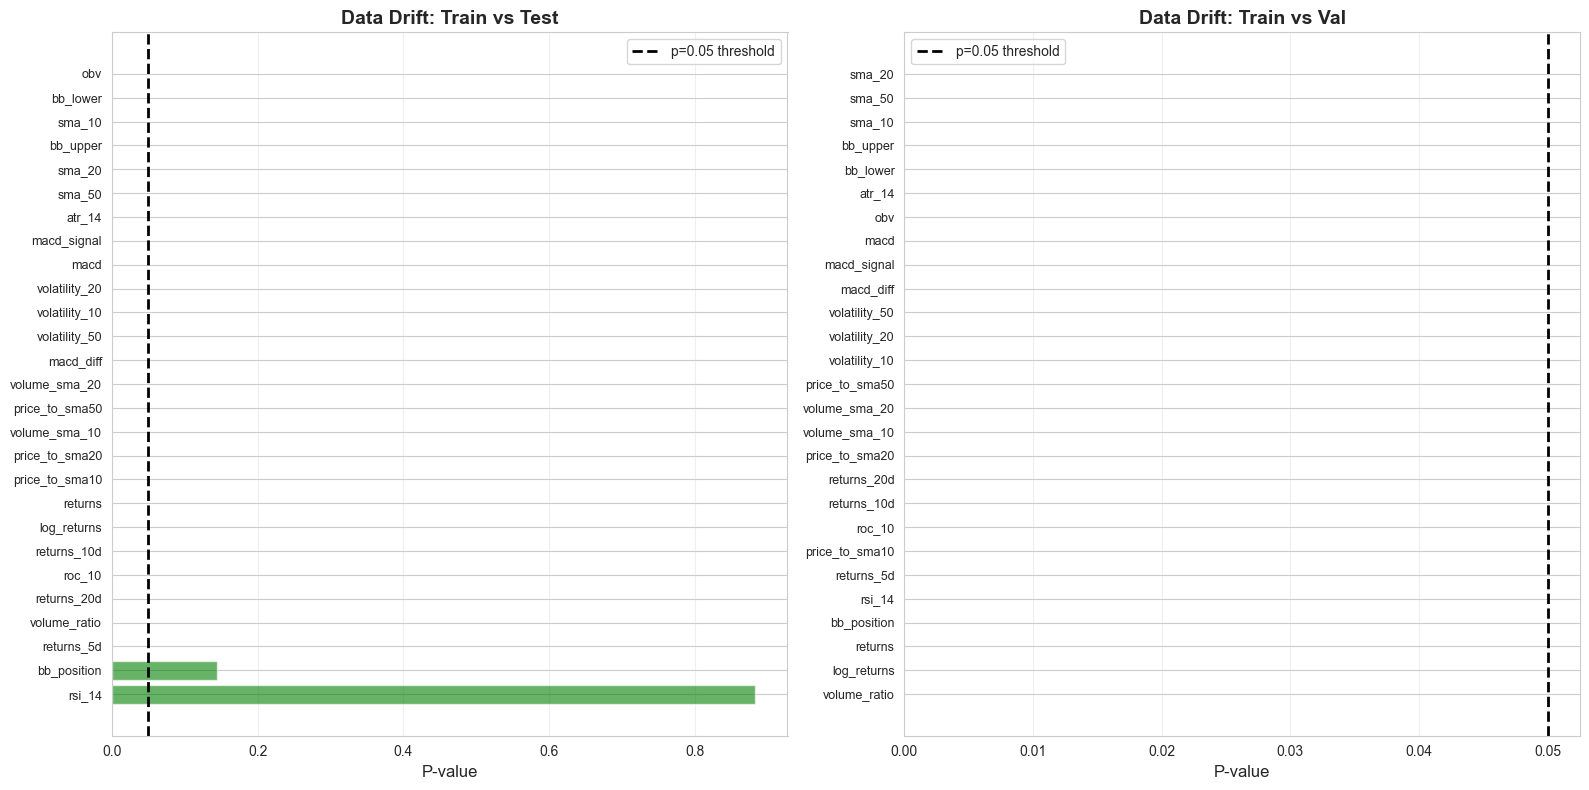

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Train vs Test
drift_test = drift_df.sort_values('p_value_test')
colors_test = ['red' if x else 'green' for x in drift_test['drift_test']]

axes[0].barh(range(len(drift_test)), drift_test['p_value_test'], color=colors_test, alpha=0.6)
axes[0].axvline(x=0.05, color='black', linestyle='--', linewidth=2, label='p=0.05 threshold')
axes[0].set_yticks(range(len(drift_test)))
axes[0].set_yticklabels(drift_test['feature'], fontsize=9)
axes[0].set_xlabel('P-value', fontsize=12)
axes[0].set_title('Data Drift: Train vs Test', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Train vs Val
drift_val = drift_df.sort_values('p_value_val')
colors_val = ['red' if x else 'green' for x in drift_val['drift_val']]

axes[1].barh(range(len(drift_val)), drift_val['p_value_val'], color=colors_val, alpha=0.6)
axes[1].axvline(x=0.05, color='black', linestyle='--', linewidth=2, label='p=0.05 threshold')
axes[1].set_yticks(range(len(drift_val)))
axes[1].set_yticklabels(drift_val['feature'], fontsize=9)
axes[1].set_xlabel('P-value', fontsize=12)
axes[1].set_title('Data Drift: Train vs Val', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/drift_summary_notebook.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Feature Distribution Comparison

Let's visualize the distributions of the top 5 most drifted features.

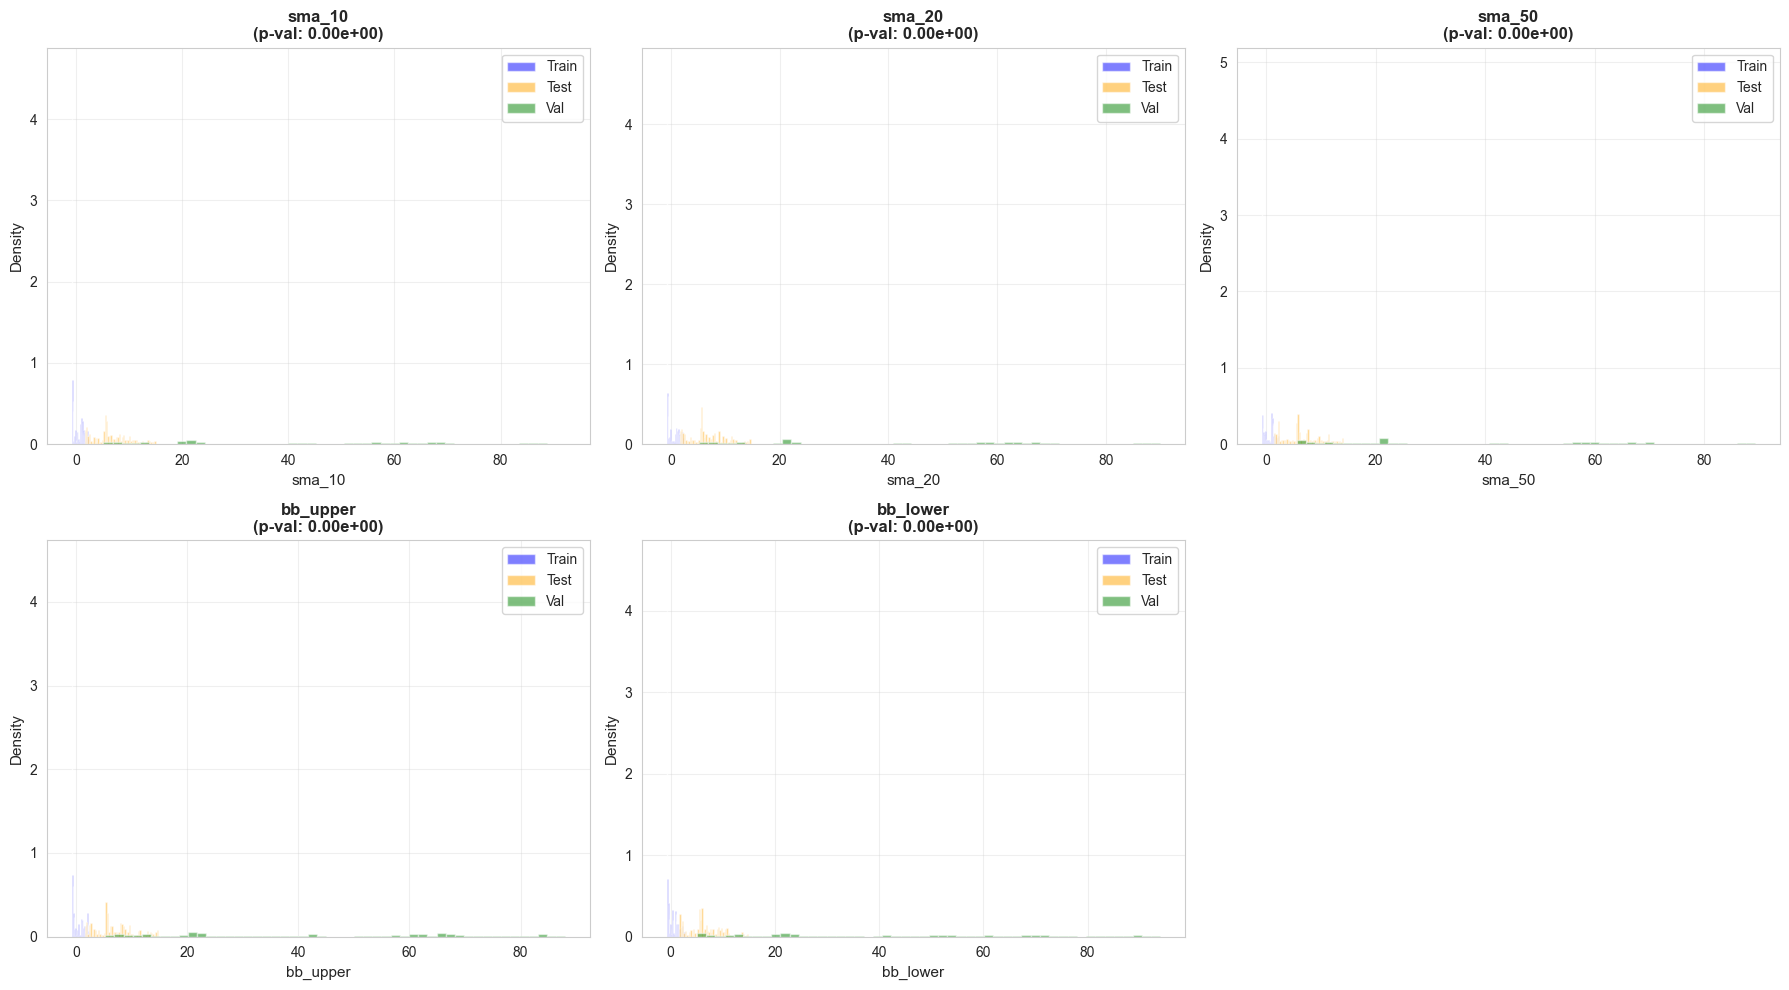

In [20]:
top_drifted = drift_df.nsmallest(5, 'p_value_val')

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(top_drifted.iterrows()):
    feature = row['feature']
    
    axes[idx].hist(train_df[feature].dropna(), bins=50, alpha=0.5, label='Train', density=True, color='blue')
    axes[idx].hist(test_df[feature].dropna(), bins=50, alpha=0.5, label='Test', density=True, color='orange')
    axes[idx].hist(val_df[feature].dropna(), bins=50, alpha=0.5, label='Val', density=True, color='green')
    
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('Density', fontsize=11)
    axes[idx].set_title(f'{feature}\n(p-val: {row["p_value_val"]:.2e})', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('../reports/top_drifted_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Timeline View: Feature Evolution Over Time

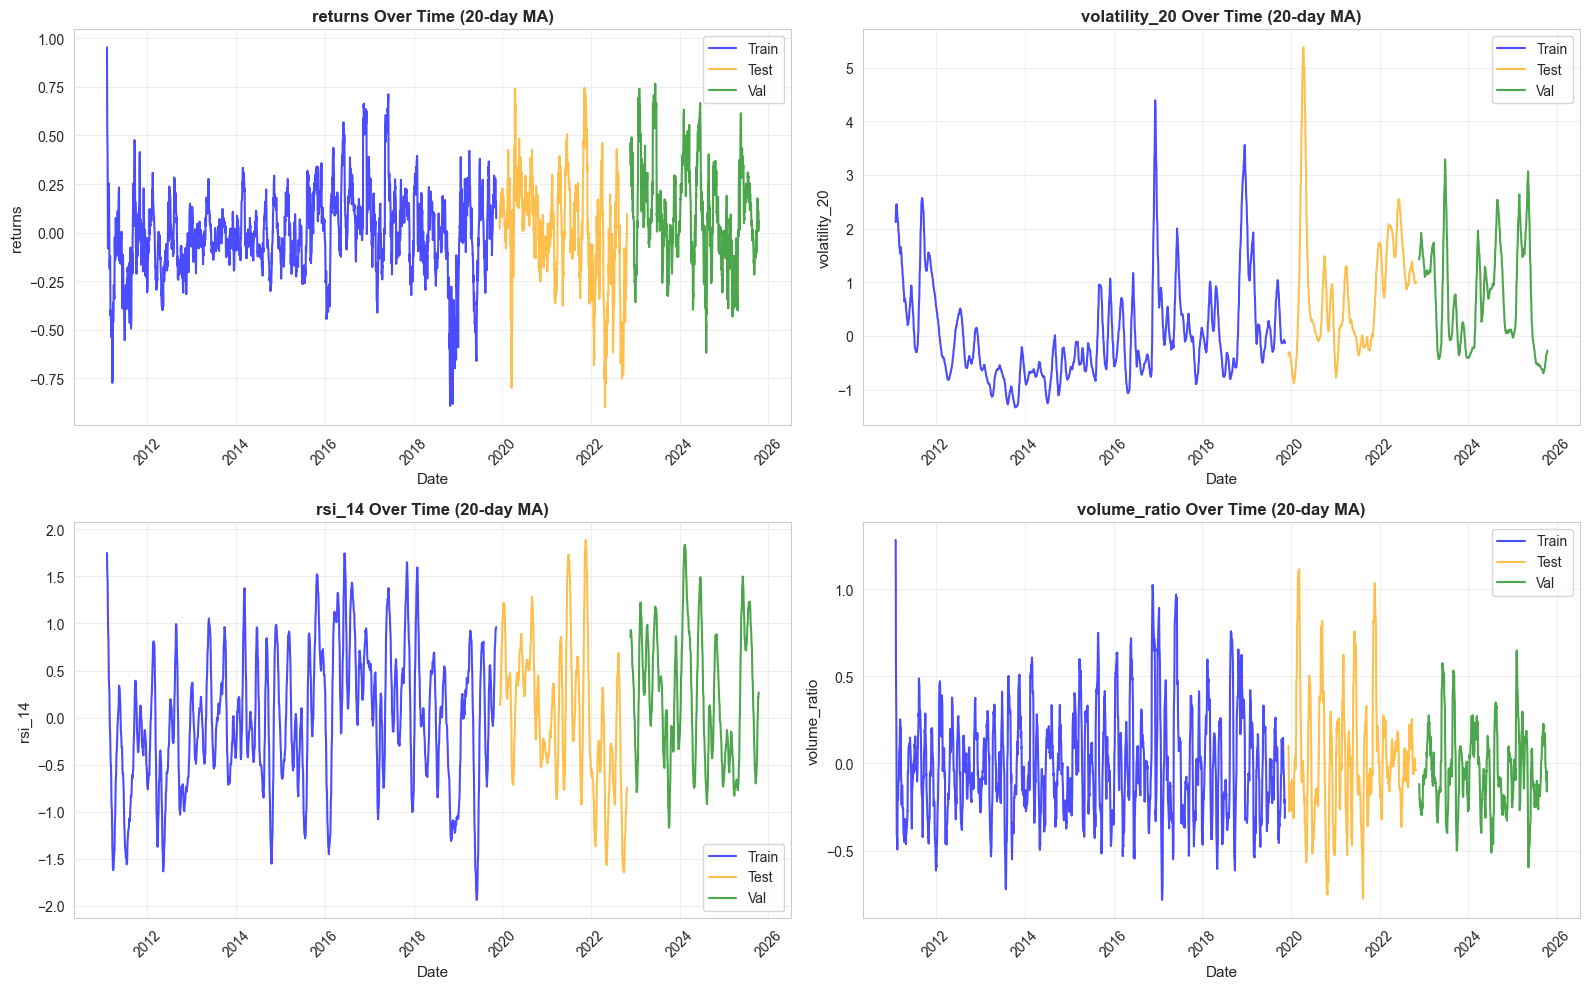

In [21]:
# Select a few key features to visualize over time
key_features = ['returns', 'volatility_20', 'rsi_14', 'volume_ratio']

# Combine all data with period labels
train_df['period'] = 'Train'
test_df['period'] = 'Test'
val_df['period'] = 'Val'
combined_df = pd.concat([train_df, test_df, val_df])

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    # Plot rolling mean
    for period, color in [('Train', 'blue'), ('Test', 'orange'), ('Val', 'green')]:
        period_data = combined_df[combined_df['period'] == period]
        rolling_mean = period_data.set_index('Date')[feature].rolling(window=20).mean()
        axes[idx].plot(rolling_mean.index, rolling_mean.values, label=period, color=color, alpha=0.7)
    
    axes[idx].set_xlabel('Date', fontsize=11)
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].set_title(f'{feature} Over Time (20-day MA)', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/feature_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Analysis Summary

### Key Findings:

1. **Severe Distribution Shift**: 27/27 features (100%) show significant drift between training and validation periods (p < 0.05)

2. **Most Drifted Features**:
   - Price-based indicators (SMA, Bollinger Bands) show KS statistic = 1.0 (maximum drift)
   - Volatility measures also show extreme drift
   - This reflects NVDA's transformation from $20B to $3T market cap

3. **Implications**:
   - Model trained on 2011-2019 data struggles with 2022-2025 market regime
   - Explains degraded performance on validation set
   - Suggests need for regular retraining or regime-aware models

4. **Market Regime Change**:
   - Train period (2011-2019): Traditional GPU/gaming growth
   - Val period (2022-2025): AI infrastructure boom
   - Fundamentally different market dynamics

In [23]:
# Save drift statistics
drift_df.to_csv('../reports/drift_statistics_notebook.csv', index=False)